<div>
    <h1 id = "title"
        style = "background-color: #2788f9;
                 border-radius: 9px;
                 border-left:15px #1e3772 solid;
                 color: #f8f8f8;
                 line-height: 34px;
                 padding: 15px 0px 15px 20px; 
                 font-size: 28px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">Chinese License Plate Recognition [YOLOv8 + CnOCR]
        <a class="anchor-link" id="title" href="chinese-license-plate-recognition-yolov8-cnocr#title">¶</a>
    </h1>
</div>

![Vehicle registration plates of China - Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/China_Fujian_Sanming_license_plate.jpg/1200px-China_Fujian_Sanming_license_plate.jpg)

<div>
    <h1 id = "preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">1. Preparation
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#preparation">¶</a>
    </h1>
</div>

In [8]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
from numba import cuda

In [9]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
BASE_PATH = "CCPD_data"

<div class="alert alert-block alert-info" style="color: black; font-size: 15px; font-family: Trebuchet MS">
    <b>Sub Datasets</b>:
    <ul>
        <li><b>CCPD-Base</b>: The only common feature of these photos is the inclusion of a license plate</li>
        <li><b>CCPD-FN</b>: The distance from the LP to the shooting location is relatively far or near</li>
        <li><b>CCPD-DB</b>: Illuminations on the LP area are dark, uneven or extremely bright</li>
        <li><b>CCPD-Rotate</b>: Great horizontal tilt degree (20◦
 50◦) and the vertical tilt degree varies from -10◦ to 10</li>
        <li><b>CCPD-Weather</b>: Images taken on a rainy day, snow day or fog day</li>
        <li><b>CCPD-Blur</b>: Blurry largely due to hand jitter while taking pictures</li>
    </ul>
</div>

<div>
    <h1 id = "data-exploration"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2. Data Exploration
        <a class="anchor-link" id="data-exploration" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#data-exploration">¶</a>
    </h1>
</div>

<div>
    <h2 id = "sample-images"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.1. Sample Images
    </h2>
</div>

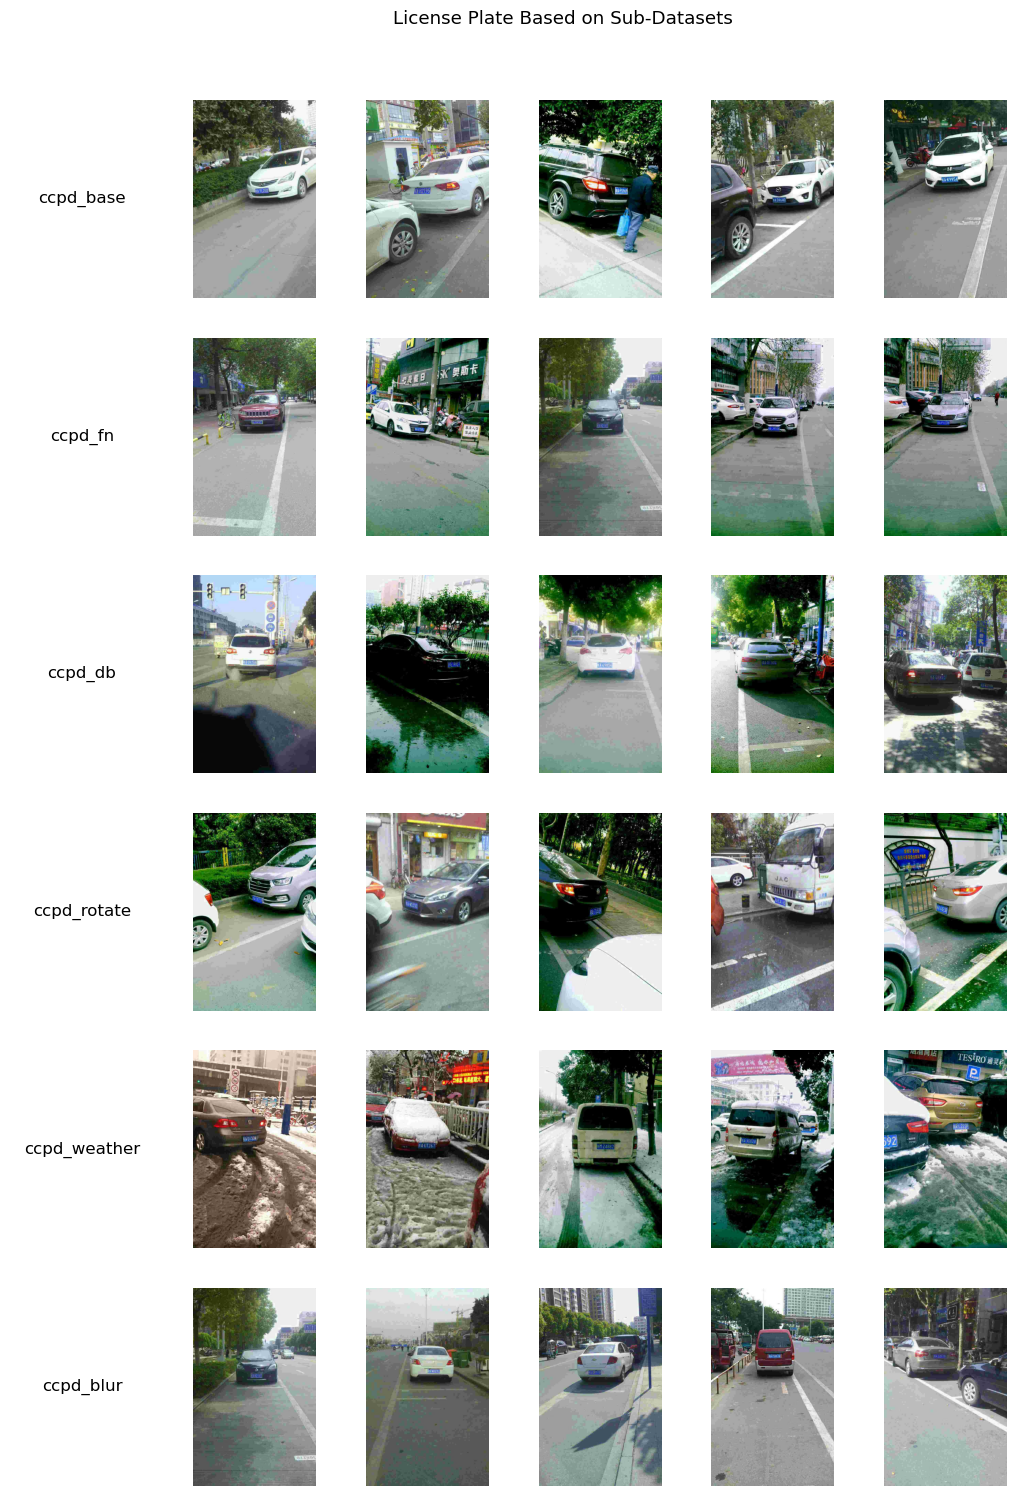

In [38]:
# Sample Images

# Create Subplots
fig, axs = plt.subplots(6, 6, figsize=(13, 18))

# Plot the Data
for i, sub in enumerate(list_sub):    
    axs[i, 0].text(0.5, 0.5, sub, ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off')
    
    sub_path = os.path.join(BASE_PATH, sub).replace("\\","/")
    sub_files = os.listdir(sub_path)[:5]

    for j in range(5):
        file_name = os.path.join(sub_path, sub_files[j]).replace("\\","/")
        image = cv2.imread(file_name)
        plt.imshow(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i, j+1].imshow(image)
        axs[i, j+1].axis("off")

# Title
plt.suptitle("License Plate Based on Sub-Datasets", x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h2 id = "image-description"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.2. Image Description
    </h2>
</div>

In [11]:
# Image Description
ccpd_base_path = os.path.join(BASE_PATH, "ccpd_base")
ccpd_base_files = os.listdir(ccpd_base_path)
for file in ccpd_base_files[:3]:
    # File Name
    file_name = os.path.join(ccpd_base_path, file)
    file_splitting = file_name.split("/")[-1][:-4]
    file_splitting = file_splitting.split("-")
    print("File Name:", file_name)
    
    # Area Ratio
    area_ratio = file_splitting[0]
    print("Area Ratio:", area_ratio)
    
    # Tilt Degrees
    tilt_degrees = file_splitting[1]
    hor_tilt_degrees = tilt_degrees.split("_")[0]
    ver_tilt_degrees = tilt_degrees.split("_")[1]
    print("Tilt Degrees")
    print("-  Horizontal:", hor_tilt_degrees)
    print("-  Vertical  :", ver_tilt_degrees)
    
    # Bounding Box
    bounding_box = file_splitting[2]
    left_up_bbox = bounding_box.split("_")[0]
    right_bot_bbox = bounding_box.split("_")[1]
    print("Bounding Box")
    print("-  Left-Up     :", left_up_bbox)
    print("-  Right-Bottom:", right_bot_bbox)
    
    # Exact Vertices
    vertices = file_splitting[3]
    right_bot_vtc = vertices.split("_")[0]
    left_bot_vtc = vertices.split("_")[1]
    left_up_vtc = vertices.split("_")[2]
    right_up_vtc = vertices.split("_")[3]
    print("Vertices")
    print("-  Right-Bottom:", right_bot_vtc)
    print("-  Left-Bottom :", left_bot_vtc)
    print("-  Left-Up     :", left_up_vtc)
    print("-  Right-Up    :", right_up_vtc)
    
    # License Plate Numbers
    lcn = file_splitting[4]
    chi_let = provinces[int(lcn.split("_")[0])]
    alp_let = alphabets[int(lcn.split("_")[1])]
    alp_num_let = lcn.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + " " + alp_num_let
    print("License Plate Number:", all_let)
    
    # Brightness
    brightness = file_splitting[5]
    print("Brightness:", brightness)
    
    # Blurriness
    blurriness = file_splitting[6]
    print("Blurriness:", blurriness)
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

File Name: CCPD_data\ccpd_base\00205459770115-90_85-352&516_448&547-444&547_368&549_364&517_440&515-0_0_22_10_26_29_24-128-7.jpg
Area Ratio: CCPD_data\ccpd_base\00205459770115
Tilt Degrees
-  Horizontal: 90
-  Vertical  : 85
Bounding Box
-  Left-Up     : 352&516
-  Right-Bottom: 448&547
Vertices
-  Right-Bottom: 444&547
-  Left-Bottom : 368&549
-  Left-Up     : 364&517
-  Right-Up    : 440&515
License Plate Number: 皖A YL250
Brightness: 128
Blurriness: 7
File Name: CCPD_data\ccpd_base\00221264367816-91_91-283&519_381&553-375&551_280&552_285&514_380&513-0_0_7_26_17_33_29-95-9.jpg
Area Ratio: CCPD_data\ccpd_base\00221264367816
Tilt Degrees
-  Horizontal: 91
-  Vertical  : 91
Bounding Box
-  Left-Up     : 283&519
-  Right-Bottom: 381&553
Vertices
-  Right-Bottom: 375&551
-  Left-Bottom : 280&552
-  Left-Up     : 285&514
-  Right-Up    : 380&513
License Plate Number: 皖A H2T95
Brightness: 95
Blurriness: 9
File Name: CCPD_data\ccpd_base\00223060344828-90_89-441&517_538&546-530&552_447&548_447

<div>
    <h2 id = "bbox-and-lpr"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.3. Sample Bounding Box and Exact Vertices
    </h2>
</div>

In [12]:
# Sample Bounding Box and Exact Vertices

# Create Subplots
fig, axs = plt.subplots(3, 4, figsize=(13, 15))

# Plot the Data
for i, file in enumerate(ccpd_base_files[2:8]):
    # File Name
    file_name = os.path.join(ccpd_base_path, file)
    file_splitting = file_name.split("/")[-1][:-4]
    file_splitting = file_splitting.split("-")
    
    # License Plate Numbers
    lcn = file_splitting[4]
    chi_let = provinces[int(lcn.split("_")[0])]
    alp_let = alphabets[int(lcn.split("_")[1])]
    alp_num_let = lcn.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    
    # Bounding Box
    bounding_box = file_splitting[2]
    lu_bbox = bounding_box.split("_")[0]
    x1, y1 = list(map(int, lu_bbox.split("&")))
    rb_bbox = bounding_box.split("_")[1]
    x2, y2 = list(map(int, rb_bbox.split("&")))
    
    bbox_img = cv2.imread(file_name)
    bbox_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (30, 240, 100), 10)
#     cv2.rectangle(bbox_img, (x1-50, y1-90), (x2+50, y1), (30, 240, 100), -1, 10)
    
#     # Add License Plate Number
#     textsize = cv2.getTextSize(all_let, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 4)[0]
#     textX = ((x2-x1+100) - textsize[0]) // 2
#     textY = (90 + textsize[1]) // 2
    
#     cv2.putText(bbox_img, all_let, (textX+x1-50, textY+y1-90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 4)
    
    axs[i//2, (i*2)%4].imshow(bbox_img)
    axs[i//2, (i*2)%4].set_title("Bounding Box", fontsize=8)
    axs[i//2, (i*2)%4].axis("off")
    axs[i//2, (i*2)%4]
    
    # Exact Vertices
    vertices = file_splitting[3]
    vertices_split = vertices.split("_")
    
    exver_img = cv2.imread(file_name)
    exver_img = cv2.cvtColor(exver_img, cv2.COLOR_BGR2RGB)
    for j in range(4):
        x1, y1 = list(map(int, vertices_split[j].split("&")))
        x2, y2 = list(map(int, vertices_split[(j+1)%4].split("&")))
        cv2.line(exver_img, (x1, y1), (x2, y2), (30, 240, 100), thickness=10)
        
    axs[i//2, (i*2+1)%4].imshow(exver_img)
    axs[i//2, (i*2+1)%4].set_title("Exact Vertices", fontsize=8)
    axs[i//2, (i*2+1)%4].axis("off")
    axs[i//2, (i*2+1)%4]

# Title
plt.suptitle("Sample Bounding Box and LPR Images", x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h1 id = "plate-detection"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3. Plate Detection - YOLOv8
        <a class="anchor-link" id="plate-detection" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#plate-detection">¶</a>
    </h1>
</div>

<div>
    <h2 id = "data-preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.1. Data Preparation
    </h2>
</div>

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Create Metadata</h3>
</div>

In [13]:
# Create Metadata
def extract_plate_number(plate_number):
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let

df_metadata = pd.DataFrame()
for sub in list_sub:
    sub_path = os.path.join(BASE_PATH, sub, "*")
    sub_files = glob.glob(sub_path)
    
    df_metadata = pd.concat([df_metadata, pd.DataFrame(sub_files)], axis=0)

df_metadata = df_metadata.rename(columns={0: "image_path"}).reset_index(drop=True)

df_metadata["sub"] = df_metadata["image_path"].apply(lambda x: x.split("\\")[1])
df_metadata["detail"] = df_metadata["image_path"].apply(lambda x: x.split("\\")[2])
df_metadata["bbox"] = df_metadata["detail"].apply(lambda x: x.split("-")[2])
df_metadata["x1_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[0].split("&")[0]))
df_metadata["y1_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[0].split("&")[1]))
df_metadata["x2_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[1].split("&")[0]))
df_metadata["y2_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[1].split("&")[1]))
df_metadata["plate_number"] = df_metadata["detail"].apply(lambda x: x.split("-")[4])
df_metadata["plate_number"] = df_metadata["plate_number"].apply(lambda x: extract_plate_number(x))

df_metadata = df_metadata.drop(["detail", "bbox"], axis=1)
df_metadata

image_path        sub  x1_bbox  \
0       CCPD_data\ccpd_base\00205459770115-90_85-352&5...  ccpd_base      352   
1       CCPD_data\ccpd_base\00221264367816-91_91-283&5...  ccpd_base      283   
2       CCPD_data\ccpd_base\00223060344828-90_89-441&5...  ccpd_base      441   
3       CCPD_data\ccpd_base\00224137931034-90_87-351&5...  ccpd_base      351   
4       CCPD_data\ccpd_base\00227490421455-90_88-341&4...  ccpd_base      341   
...                                                   ...        ...      ...   
271753  CCPD_data\ccpd_blur\1695-0_10-0&407_719&604-71...  ccpd_blur        0   
271754  CCPD_data\ccpd_blur\1730-4_17-28&393_662&621-6...  ccpd_blur       28   
271755  CCPD_data\ccpd_blur\1740-8_3-92&341_549&659-52...  ccpd_blur       92   
271756  CCPD_data\ccpd_blur\1842-21_32-57&324_498&673-...  ccpd_blur       57   
271757  CCPD_data\ccpd_blur\1913-25_30-96&247_509&634-...  ccpd_blur       96   

        y1_bbox  x2_bbox  y2_bbox plate_number  
0           516      448      547      皖AYL250  
1           519      381      553      皖AH2T95  
2           517      538      546      皖APS969  
3           564      451      606      皖ADX640  
4           443      436      482      皖AK9954  
...         ...      ...      ...          ...  
271753      407      719      604      皖DJ0282  
271754      393      662      621      皖AV3A71  
271755      341      549      659      皖AY1A26  
271756      324      498      673      皖A33961  
271757      247      509      634      皖AKX160  

[271758 rows x 7 columns]

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Create YOLOv8 Bounding Box Format</h3>
</div>

In [14]:
df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2*720)
df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2*1160)

df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / 720
df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / 1160

df_metadata

image_path        sub  x1_bbox  \
0       CCPD_data\ccpd_base\00205459770115-90_85-352&5...  ccpd_base      352   
1       CCPD_data\ccpd_base\00221264367816-91_91-283&5...  ccpd_base      283   
2       CCPD_data\ccpd_base\00223060344828-90_89-441&5...  ccpd_base      441   
3       CCPD_data\ccpd_base\00224137931034-90_87-351&5...  ccpd_base      351   
4       CCPD_data\ccpd_base\00227490421455-90_88-341&4...  ccpd_base      341   
...                                                   ...        ...      ...   
271753  CCPD_data\ccpd_blur\1695-0_10-0&407_719&604-71...  ccpd_blur        0   
271754  CCPD_data\ccpd_blur\1730-4_17-28&393_662&621-6...  ccpd_blur       28   
271755  CCPD_data\ccpd_blur\1740-8_3-92&341_549&659-52...  ccpd_blur       92   
271756  CCPD_data\ccpd_blur\1842-21_32-57&324_498&673-...  ccpd_blur       57   
271757  CCPD_data\ccpd_blur\1913-25_30-96&247_509&634-...  ccpd_blur       96   

        y1_bbox  x2_bbox  ...  plate_number      xmid      ymid  bb_width  \
0           516      448  ...       皖AYL250  0.555556  0.458190  0.133333   
1           519      381  ...       皖AH2T95  0.461111  0.462069  0.136111   
2           517      538  ...       皖APS969  0.679861  0.458190  0.134722   
3           564      451  ...       皖ADX640  0.556944  0.504310  0.138889   
4           443      436  ...       皖AK9954  0.539583  0.398707  0.131944   
...         ...      ...  ...           ...       ...       ...       ...   
271753      407      719  ...       皖DJ0282  0.499306  0.435776  0.998611   
271754      393      662  ...       皖AV3A71  0.479167  0.437069  0.880556   
271755      341      549  ...       皖AY1A26  0.445139  0.431034  0.634722   
271756      324      498  ...       皖A33961  0.385417  0.429741  0.612500   
271757      247      509  ...       皖AKX160  0.420139  0.379741  0.573611   

        bb_height  
0        0.026724  
1        0.029310  
2        0.025000  
3        0.036207  
4        0.033621  
...           ...  
271753   0.169828  
271754   0.196552  
271755   0.274138  
271756   0.300862  
271757   0.333621  

[271758 rows x 11 columns]

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Data Splitting</h3>
</div>

In [15]:
df_metadata = df_metadata.iloc[:5500]

# Train : 5000 (ccpd_base), Val and Test : 50 for each sub (except ccpd_base)
list_split = ["train"] * 5000
for i in range(5):
    list_split.extend(["val"]*50)
    list_split.extend(["test"]*50)
df_metadata["split"] = list_split
df_metadata

image_path        sub  x1_bbox  \
0     CCPD_data\ccpd_base\00205459770115-90_85-352&5...  ccpd_base      352   
1     CCPD_data\ccpd_base\00221264367816-91_91-283&5...  ccpd_base      283   
2     CCPD_data\ccpd_base\00223060344828-90_89-441&5...  ccpd_base      441   
3     CCPD_data\ccpd_base\00224137931034-90_87-351&5...  ccpd_base      351   
4     CCPD_data\ccpd_base\00227490421455-90_88-341&4...  ccpd_base      341   
...                                                 ...        ...      ...   
5495  CCPD_data\ccpd_base\00741379310345-92_92-271&3...  ccpd_base      271   
5496  CCPD_data\ccpd_base\00741618773946-90_85-293&5...  ccpd_base      293   
5497  CCPD_data\ccpd_base\00742337164751-85_92-304&4...  ccpd_base      304   
5498  CCPD_data\ccpd_base\00742337164751-86_94-300&4...  ccpd_base      300   
5499  CCPD_data\ccpd_base\00742337164751-88_93-287&5...  ccpd_base      287   

      y1_bbox  x2_bbox  ...      xmid      ymid  bb_width  bb_height  split  
0         516      448  ...  0.555556  0.458190  0.133333   0.026724  train  
1         519      381  ...  0.461111  0.462069  0.136111   0.029310  train  
2         517      538  ...  0.679861  0.458190  0.134722   0.025000  train  
3         564      451  ...  0.556944  0.504310  0.138889   0.036207  train  
4         443      436  ...  0.539583  0.398707  0.131944   0.033621  train  
...       ...      ...  ...       ...       ...       ...        ...    ...  
5495      397      428  ...  0.485417  0.366379  0.218056   0.048276   test  
5496      518      476  ...  0.534028  0.470690  0.254167   0.048276   test  
5497      458      444  ...  0.519444  0.418534  0.194444   0.047414   test  
5498      485      447  ...  0.518750  0.444397  0.204167   0.052586   test  
5499      526      434  ...  0.500694  0.478448  0.204167   0.050000   test  

[5500 rows x 12 columns]

<div>
    <h2 id = "yolo-preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.2. YOLOv8 Preparation
    </h2>
</div>

In [16]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

fatal: destination path 'ultralytics' already exists and is not an empty directory.


Defaulting to user installation because normal site-packages is not writeable


In [17]:
# Create Dataset Folder in YOLOv8
!mkdir "yoloV8/datasets"
!mkdir "yoloV8/datasets/train"
!mkdir "yoloV8/datasets/val"
!mkdir "yoloV8/datasets/test"

A subdirectory or file yoloV8/datasets already exists.
A subdirectory or file yoloV8/datasets/train already exists.
A subdirectory or file yoloV8/datasets/val already exists.


A subdirectory or file yoloV8/datasets/test already exists.


In [18]:
# https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition/notebook
# Copy Image to YOLOv8 Dataset Folder and Create Text
def image_and_text_yolo(split):
    df = df_metadata[df_metadata["split"]==split].reset_index(drop=True)
    folder_path = os.path.join("yoloV8/datasets", split)
    
    values = df[['image_path','xmid','ymid','bb_width','bb_height']].values
    for file_name, x, y, w, h in values:
        image_name = os.path.split(file_name)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(folder_path, image_name)
        dst_label_file = os.path.join(folder_path, txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(file_name, dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file, mode='w') as f:
            f.write(label_txt)
            f.close()
            
image_and_text_yolo("train")
print("Train Dataset Created")
image_and_text_yolo("val")
print("Val Dataset Created")
image_and_text_yolo("test")
print("Test Dataset Created")

Train Dataset Created
Val Dataset Created
Test Dataset Created


In [49]:
%%writefile yoloV8/custom_dataset.yaml
# Create Custom Dataset Configuration
train: datasets/train
val: datasets/val
test: datasets/test
    
nc: 1
    
names: [
    'license_plate'
]

Overwriting yoloV8/custom_dataset.yaml


<div>
    <h2 id = "yolo-training"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.3. YOLOv8 Training
    </h2>
</div>

In [50]:
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Defaulting to user installation because normal site-packages is not writeable
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 21% |  9% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 35% | 10% |


In [51]:
!wandb disabled
!yolo train model=yolov8s.pt data="C:\Users\matss\Downloads\project\yoloV8\custom_dataset.yaml" epochs=25 verbose=True batch=32

'wandb' is not recognized as an internal or external command,
operable program or batch file.


Ultralytics YOLOv8.0.219 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\matss\Downloads\project\yoloV8\custom_dataset.yaml, epochs=25, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru


train: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
train: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

val: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\val.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]
val: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\val.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]
       1/25      8.14G       2.22         10      1.652         62        640:   0%|          | 0/313 [00:01<?, ?it/s]
       1/25      8.14G       2.22         10      1.652         62        640:   0%|          | 1/313 [00:01<09:54,  1.91s/it]
       1/25      8.14G      2.053      9.867      1.564         74 

In [19]:
os.listdir("runs/detect/train")

['args.yaml',
 'confusion_matrix.png',
 'confusion_matrix_normalized.png',
 'F1_curve.png',
 'labels.jpg',
 'labels_correlogram.jpg',
 'PR_curve.png',
 'P_curve.png',
 'results.csv',
 'results.png',
 'R_curve.png',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'train_batch4695.jpg',
 'train_batch4696.jpg',
 'train_batch4697.jpg',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'weights']

<div>
    <h2 id = "loss-metrics-evaluation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.4. Loss and Metrics Evaluation
    </h2>
</div>

In [21]:
training_results = pd.read_csv("runs/detect/train/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1          1.3881         1.11580          1.0983   
1       2          1.3628         0.58295          1.1646   
2       3          1.3540         0.55400          1.1668   
3       4          1.3494         0.55094          1.1626   
4       5          1.3272         0.52665          1.1470   
5       6          1.3176         0.51683          1.1420   
6       7          1.3087         0.50232          1.1387   
7       8          1.3065         0.49378          1.1359   
8       9          1.2997         0.48996          1.1346   
9      10          1.2898         0.48442          1.1268   
10     11          1.2839         0.47612          1.1220   
11     12          1.2873         0.47489          1.1211   
12     13          1.2748         0.46881          1.1205   
13     14          1.2723         0.46041          1.1209   
14     15          1.2633         0.45537          1.1104   
15     16          1.2768         0.43163          1.1987   
16     17          1.2663         0.42588          1.1939   
17     18          1.2594         0.42356          1.1925   
18     19          1.2566         0.41462          1.1874   
19     20          1.2486         0.40716          1.1824   
20     21          1.2428         0.40568          1.1802   
21     22          1.2389         0.40014          1.1773   
22     23          1.2374         0.39773          1.1765   
23     24          1.2304         0.38993          1.1682   
24     25          1.2247         0.38529          1.1650   

    metrics/precision(B)  ...  val/cls_loss  val/dfl_loss    lr/pg0    lr/pg1  \
0                0.99729  ...       0.67354        1.2484  0.000665  0.000665   
1                0.99315  ...       0.51940        1.2527  0.001278  0.001278   
2                0.98683  ...       0.51871        1.2343  0.001840  0.001840   
3                0.98916  ...       0.51784        1.2509  0.001762  0.001762   
4                0.99943  ...       0.47149        1.2196  0.001762  0.001762   
5                1.00000  ...       0.44835        1.2286  0.001683  0.001683   
6                0.99792  ...       0.43154        1.2006  0.001604  0.001604   
7                0.99980  ...       0.44238        1.2093  0.001525  0.001525   
8                0.99968  ...       0.43034        1.2550  0.001446  0.001446   
9                0.99776  ...       0.40818        1.2070  0.001366  0.001366   
10               1.00000  ...       0.41376        1.1894  0.001287  0.001287   
11               0.99983  ...       0.43186        1.1857  0.001208  0.001208   
12               0.99984  ...       0.39502        1.2038  0.001129  0.001129   
13               0.99930  ...       0.41052        1.1861  0.001050  0.001050   
14               0.99961  ...       0.39430        1.1867  0.000970  0.000970   
15               0.99817  ...       0.39115        1.1723  0.000891  0.000891   
16               0.99960  ...       0.39222        1.1795  0.000812  0.000812   
17               0.99985  ...       0.38125        1.1703  0.000733  0.000733   
18               0.99982  ...       0.37656        1.1733  0.000654  0.000654   
19               0.99979  ...       0.37376        1.1668  0.000574  0.000574   
20               0.99987  ...       0.37357        1.1599  0.000495  0.000495   
21               0.99982  ...       0.36540        1.1744  0.000416  0.000416   
22               0.99978  ...       0.36335        1.1646  0.000337  0.000337   
23               0.99985  ...       0.36026        1.1645  0.000258  0.000258   
24               0.99985  ...       0.35761        1.1610  0.000178  0.000178   

      lr/pg2  
0   0.000665  
1   0.001278  
2   0.001840  
3   0.001762  
4   0.001762  
5   0.001683  
6   0.001604  
7   0.001525  
8   0.001446  
9   0.001366  
10  0.001287  
11  0.001208  
12  0.001129  
13  0.001050  
14  0.000970  
15  0.000891  
16  0.000812  
17  0.000733  
18  0.000654  
19  0.0005

In [22]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss", "Distributional Focal Loss"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss", "dfl_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss", "DFL Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [23]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall", "mAP50", "mAP50-95"]
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles, 
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall", "mAP50", "mAP50-95"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )
    
    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=600,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

<div>
    <h2 id = "yolov8-testing"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.5. YOLOv8 Testing
    </h2>
</div>

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Model Testing</h3>
</div>

In [24]:
!yolo val model="C:\Users\matss\Downloads\project\runs\detect\train\weights\best.pt" data="C:\Users\matss\Downloads\project\yoloV8\custom_dataset.yaml" split="test"

Ultralytics YOLOv8.0.219 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
                   all        525        525          1          1      0.995      0.702
Speed: 0.4ms preprocess, 4.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val2
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\test.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]
val: Scanning C:\Users\matss\Downloads\project\yoloV8\datasets\test.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/33 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 1/33 [00:00<00:28,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 2/33 [00:01<00:15,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 3/33 [00:01<00:12,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 4/33 [00:01<00:09,  2.93it/s]
       

In [25]:
os.listdir("runs/detect/val")

['confusion_matrix.png',
 'confusion_matrix_normalized.png',
 'F1_curve.png',
 'PR_curve.png',
 'P_curve.png',
 'R_curve.png',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg']

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Testing Metrics</h3>
</div>

In [26]:
# Confusion Matrix
fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("runs/detect/val/confusion_matrix.png")
plt.imshow(cm_img)
plt.axis("off")
fig.show()

In [27]:
# Testing Curve
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "runs/detect/val/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')
    
# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h2 id = "bbox-predictions"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.6. Get Bounding Box Predictions
    </h2>
</div>

In [28]:
df_results = df_metadata[df_metadata["split"]=="test"].reset_index(drop=True)
df_results = df_results[["image_path", "sub", "plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_results

image_path        sub  \
0    CCPD_data\ccpd_base\00727011494253-88_89-346&3...  ccpd_base   
1    CCPD_data\ccpd_base\00727011494253-88_90-264&4...  ccpd_base   
2    CCPD_data\ccpd_base\00727011494253-88_92-279&4...  ccpd_base   
3    CCPD_data\ccpd_base\00727011494253-89_85-242&4...  ccpd_base   
4    CCPD_data\ccpd_base\00727011494253-89_91-186&4...  ccpd_base   
..                                                 ...        ...   
245  CCPD_data\ccpd_base\00741379310345-92_92-271&3...  ccpd_base   
246  CCPD_data\ccpd_base\00741618773946-90_85-293&5...  ccpd_base   
247  CCPD_data\ccpd_base\00742337164751-85_92-304&4...  ccpd_base   
248  CCPD_data\ccpd_base\00742337164751-86_94-300&4...  ccpd_base   
249  CCPD_data\ccpd_base\00742337164751-88_93-287&5...  ccpd_base   

    plate_number  x1_bbox  y1_bbox  x2_bbox  y2_bbox  
0        苏K131V3      346      305      491      364  
1        皖ADL888      264      445      424      508  
2        皖A61V95      279      469      433      515  
3        皖ANN918      242      455      404      513  
4        京KN9235      186      463      334      518  
..           ...      ...      ...      ...      ...  
245      皖ARC633      271      397      428      453  
246      皖AH246F      293      518      476      574  
247      皖A13979      304      458      444      513  
248      皖A30H36      300      485      447      546  
249      皖A6R000      287      526      434      584  

[250 rows x 7 columns]

In [29]:
# Get Bounding Box Predictions
from ultralytics import YOLO

yolo_model = YOLO('runs/detect/train/weights/best.pt')
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []
for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)
    
    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

In [30]:
df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results

image_path        sub  \
0    CCPD_data\ccpd_base\00727011494253-88_89-346&3...  ccpd_base   
1    CCPD_data\ccpd_base\00727011494253-88_90-264&4...  ccpd_base   
2    CCPD_data\ccpd_base\00727011494253-88_92-279&4...  ccpd_base   
3    CCPD_data\ccpd_base\00727011494253-89_85-242&4...  ccpd_base   
4    CCPD_data\ccpd_base\00727011494253-89_91-186&4...  ccpd_base   
..                                                 ...        ...   
245  CCPD_data\ccpd_base\00741379310345-92_92-271&3...  ccpd_base   
246  CCPD_data\ccpd_base\00741618773946-90_85-293&5...  ccpd_base   
247  CCPD_data\ccpd_base\00742337164751-85_92-304&4...  ccpd_base   
248  CCPD_data\ccpd_base\00742337164751-86_94-300&4...  ccpd_base   
249  CCPD_data\ccpd_base\00742337164751-88_93-287&5...  ccpd_base   

    plate_number  x1_bbox  y1_bbox  x2_bbox  y2_bbox               pred_bbox  \
0        苏K131V3      346      305      491      364  [[344, 307, 499, 365]]   
1        皖ADL888      264      445      424      508  [[277, 458, 427, 508]]   
2        皖A61V95      279      469      433      515  [[278, 466, 437, 523]]   
3        皖ANN918      242      455      404      513  [[244, 457, 407, 516]]   
4        京KN9235      186      463      334      518  [[183, 466, 335, 519]]   
..           ...      ...      ...      ...      ...                     ...   
245      皖ARC633      271      397      428      453  [[269, 390, 426, 448]]   
246      皖AH246F      293      518      476      574  [[287, 521, 472, 577]]   
247      皖A13979      304      458      444      513  [[308, 460, 447, 511]]   
248      皖A30H36      300      485      447      546  [[298, 486, 442, 545]]   
249      皖A6R000      287      526      434      584  [[281, 524, 431, 582]]   

    confidence  
0       [0.77]  
1       [0.77]  
2       [0.78]  
3       [0.79]  
4       [0.77]  
..         ...  
245     [0.79]  
246     [0.78]  
247     [0.76]  
248     [0.74]  
249     [0.76]  

[250 rows x 9 columns]

<div>
    <h2 id = "show-test-images-detection"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.7. Show Test Images after Detection
    </h2>
</div>

CCPD_data\ccpd_base\00727011494253-88_89-346&305_491&364-494&365_348&367_349&314_495&312-10_9_25_27_25_19_27-85-7.jpg


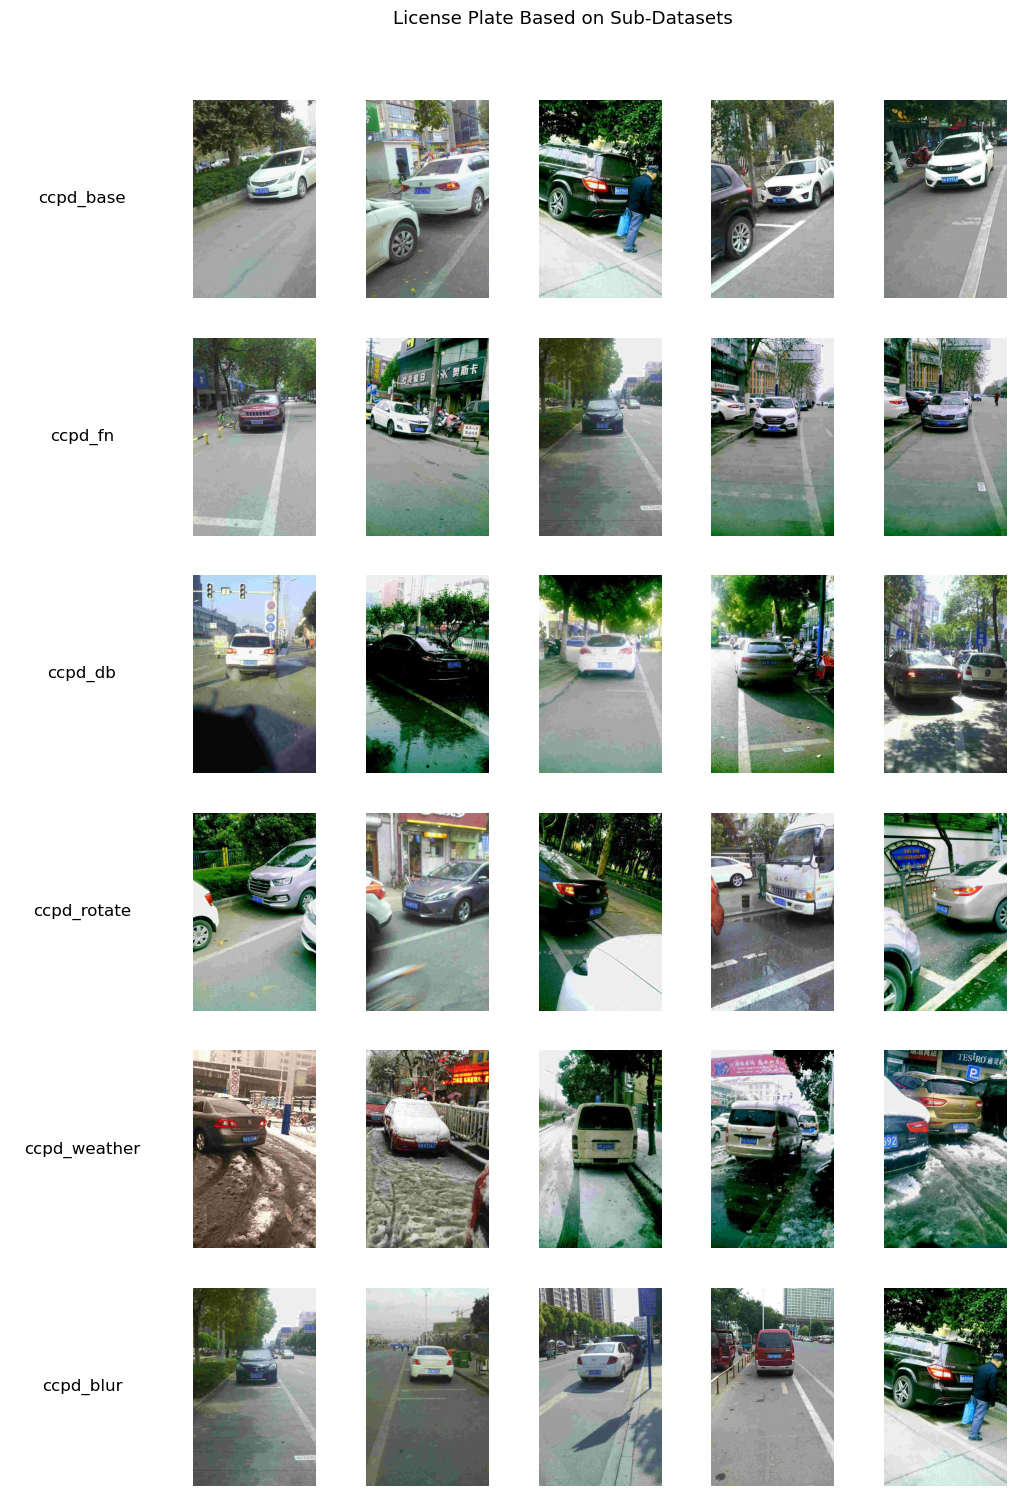

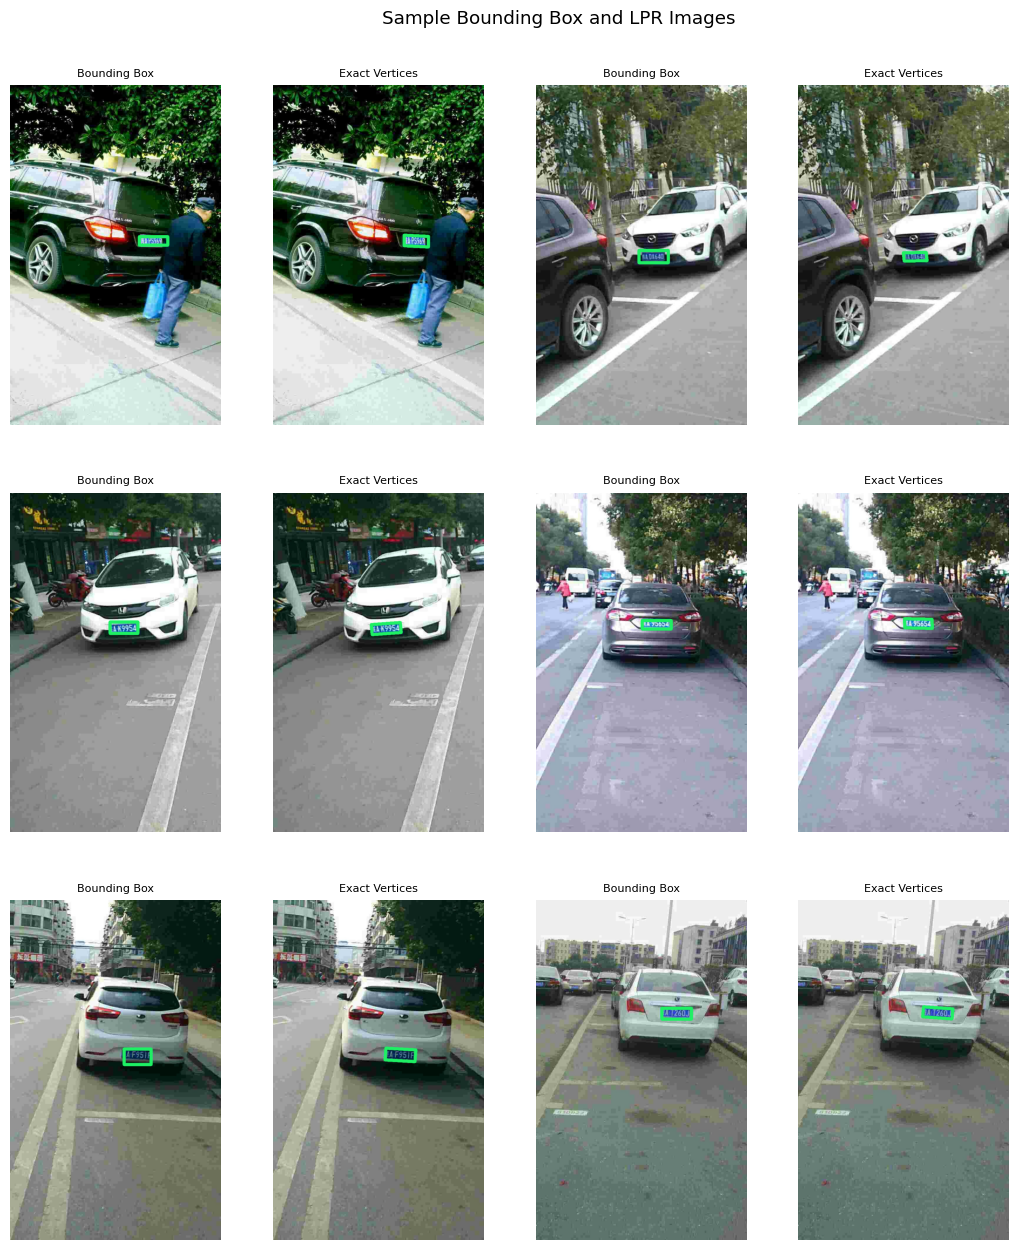

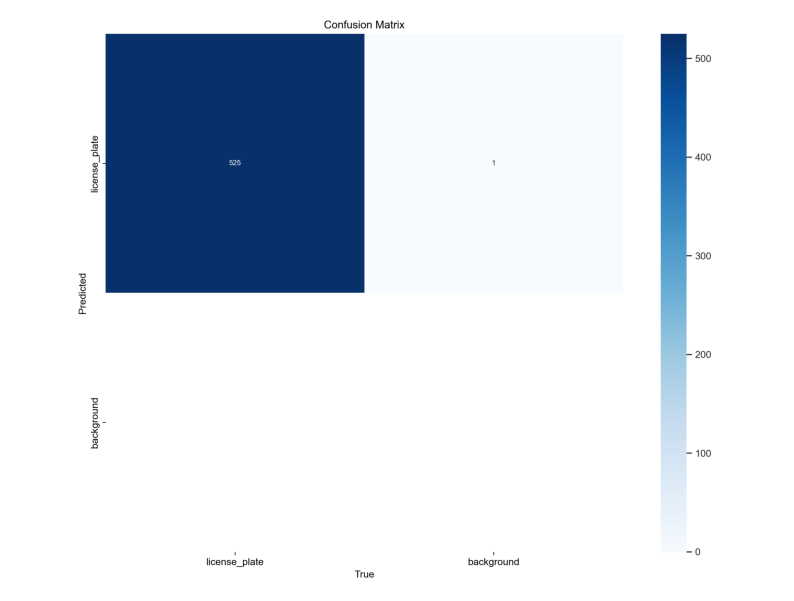

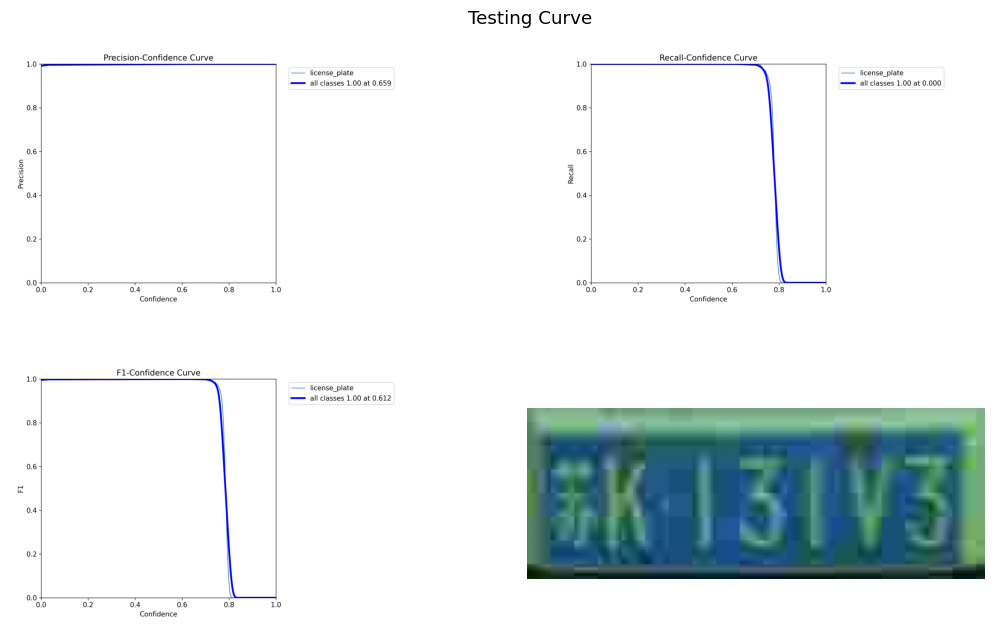

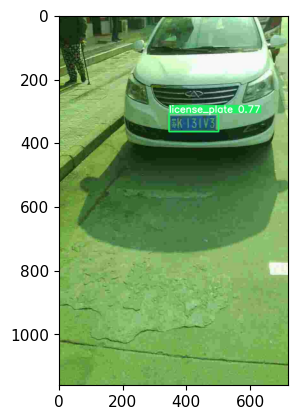

CCPD_data\ccpd_base\00731082375479-90_88-248&551_440&607-431&605_245&611_242&550_428&544-0_0_30_12_27_26_30-142-10.jpg


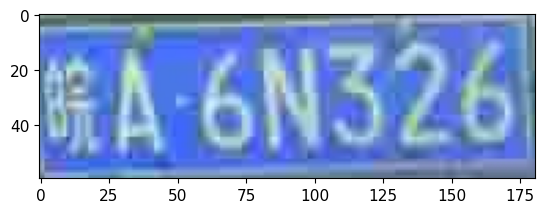

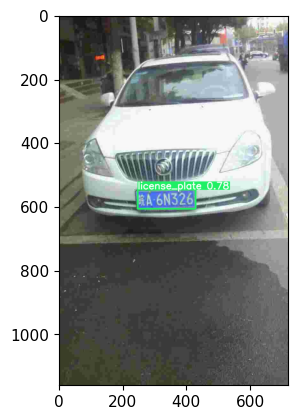

CCPD_data\ccpd_base\0073275862069-92_85-324&463_472&518-466&516_332&505_331&459_465&470-0_0_15_25_28_25_26-146-34.jpg


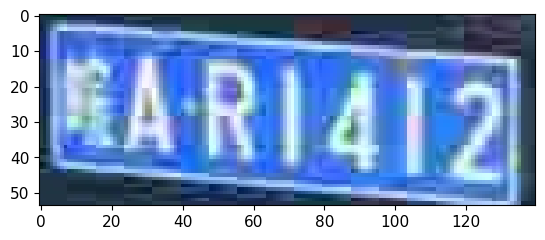

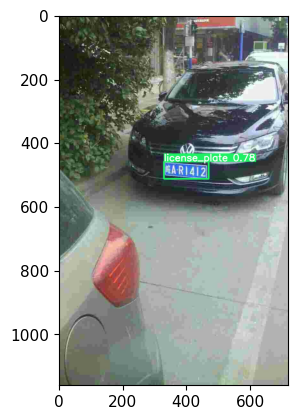

CCPD_data\ccpd_base\00737547892721-90_86-290&471_444&529-441&538_287&535_288&483_442&486-0_0_32_25_11_25_31-75-9.jpg


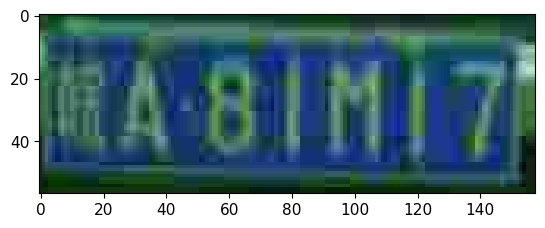

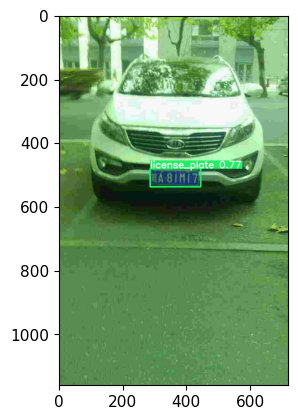

CCPD_data\ccpd_base\00741259578545-90_86-227&577_397&637-390&633_227&628_226&574_389&579-0_0_6_9_29_32_27-66-5.jpg


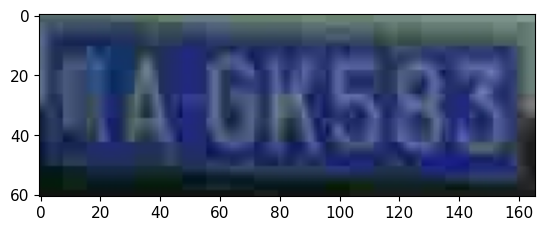

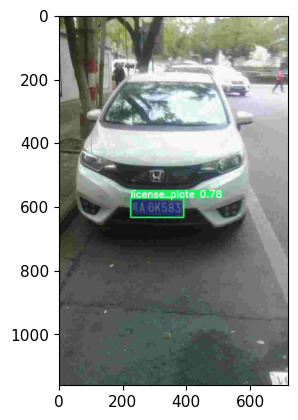

In [31]:
%matplotlib inline
from ultralytics.utils.plotting import Annotator

def show_plate_detection(idx):
    # Original Image
    ori_path = df_results["image_path"][idx]
    print(ori_path)
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    # Annotate Box
    annotator = Annotator(ori_image.copy())
    boxes = df_results["pred_bbox"][idx]
    confs = df_results["confidence"][idx]
    for i, box in enumerate(boxes):
        annotator.box_label(box=box, label="license_plate " + (str(confs[i])), color=(30, 240, 100))

        # Get Plate Object
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = ori_image[y1:y2, x1:x2]
        plt.imshow(roi)
        plt.show()

    # Show Image
    frame = annotator.result()
    plt.imshow(frame)
    plt.show()

idxs = [0, 50, 100, 150, 200]
for idx in idxs:
    show_plate_detection(idx)

<div>
    <h1 id = "plate-recognition"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">4. Plate Recognition - CnOCR
        <a class="anchor-link" id="plate-recognition" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#plate-recognition">¶</a>
    </h1>
</div>

<div>
    <h2 id = "text-predictions"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">4.1. Get Text Predictions
    </h2>
</div>

In [32]:
!pip install cnocr

Defaulting to user installation because normal site-packages is not writeable


In [33]:
from cnocr import CnOcr

def get_text_cnocr(idx):
    ori_path = df_results["image_path"][idx]
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
    cnocr_model = CnOcr()
    text_list = []
    bboxs = df_results["pred_bbox"][idx]
    for bbox in bboxs:
        # Crop Image with Bounding Box
        crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        
        # Extract Plate Number
        text_output = cnocr_model.ocr(crop_image)
        if(len(text_output)>0):
            text = text_output[0]["text"]
            
            # Clean Text
            del_punc_list = [" ", "·", ":", "-"]
            clean_text = re.sub(r"[ ·:-]", "", text)
            clean_text = clean_text.replace("O", "0")
            clean_text = clean_text.replace("I", "1")
            clean_text = clean_text.upper()
            text_list.append(clean_text)
            
    return text_list

In [36]:
idxs = list(np.arange(0, 250))
text_results = tqdm([get_text_cnocr(idx) for idx in idxs])
text_results = [text[0] if len(text)>0 else "" for text in text_results]
df_results["pred_plate_number"] = text_results
df_results

[WARNING 2023-11-29 04:52:34,336 _assert_and_prepare_model_files:124] can not find model file C:\Users\matss\AppData\Roaming\cnstd\1.2\ppocr\ch_PP-OCRv3_det_infer.onnx 
2171KB [00:01, 1615.36KB/s]                          
100%|██████████| 250/250 [00:00<?, ?it/s]


image_path        sub  \
0    CCPD_data\ccpd_base\00727011494253-88_89-346&3...  ccpd_base   
1    CCPD_data\ccpd_base\00727011494253-88_90-264&4...  ccpd_base   
2    CCPD_data\ccpd_base\00727011494253-88_92-279&4...  ccpd_base   
3    CCPD_data\ccpd_base\00727011494253-89_85-242&4...  ccpd_base   
4    CCPD_data\ccpd_base\00727011494253-89_91-186&4...  ccpd_base   
..                                                 ...        ...   
245  CCPD_data\ccpd_base\00741379310345-92_92-271&3...  ccpd_base   
246  CCPD_data\ccpd_base\00741618773946-90_85-293&5...  ccpd_base   
247  CCPD_data\ccpd_base\00742337164751-85_92-304&4...  ccpd_base   
248  CCPD_data\ccpd_base\00742337164751-86_94-300&4...  ccpd_base   
249  CCPD_data\ccpd_base\00742337164751-88_93-287&5...  ccpd_base   

    plate_number  x1_bbox  y1_bbox  x2_bbox  y2_bbox               pred_bbox  \
0        苏K131V3      346      305      491      364  [[344, 307, 499, 365]]   
1        皖ADL888      264      445      424      508  [[277, 458, 427, 508]]   
2        皖A61V95      279      469      433      515  [[278, 466, 437, 523]]   
3        皖ANN918      242      455      404      513  [[244, 457, 407, 516]]   
4        京KN9235      186      463      334      518  [[183, 466, 335, 519]]   
..           ...      ...      ...      ...      ...                     ...   
245      皖ARC633      271      397      428      453  [[269, 390, 426, 448]]   
246      皖AH246F      293      518      476      574  [[287, 521, 472, 577]]   
247      皖A13979      304      458      444      513  [[308, 460, 447, 511]]   
248      皖A30H36      300      485      447      546  [[298, 486, 442, 545]]   
249      皖A6R000      287      526      434      584  [[281, 524, 431, 582]]   

    confidence pred_plate_number  
0       [0.77]           苏K131V3  
1       [0.77]          佳AD1L888  
2       [0.78]           皖A61V95  
3       [0.79]           宝ANN918  
4       [0.77]            京N9235  
..         ...               ...  
245     [0.79]           皖ARC633  
246     [0.78]                    
247     [0.76]            A13979  
248     [0.74]          埃A30H136  
249     [0.76]           宝A6R000  

[250 rows x 10 columns]

<div>
    <h2 id = "show-test-images-detection"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">4.2. Show Test Images after Text Recognition
    </h2>
</div>

CCPD_data\ccpd_base\00727011494253-88_89-346&305_491&364-494&365_348&367_349&314_495&312-10_9_25_27_25_19_27-85-7.jpg


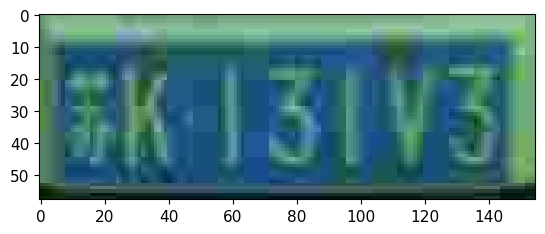

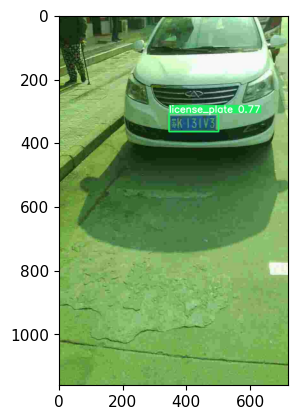

['苏K131V3']
CCPD_data\ccpd_base\00731082375479-90_88-248&551_440&607-431&605_245&611_242&550_428&544-0_0_30_12_27_26_30-142-10.jpg


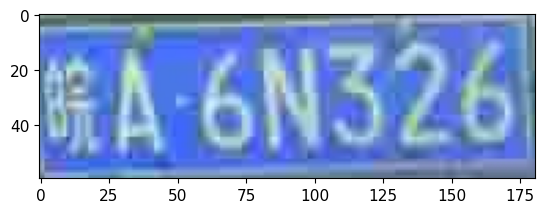

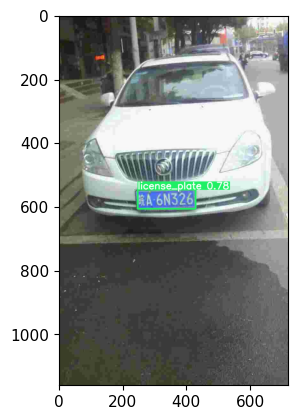

['皖A6N326']
CCPD_data\ccpd_base\0073275862069-92_85-324&463_472&518-466&516_332&505_331&459_465&470-0_0_15_25_28_25_26-146-34.jpg


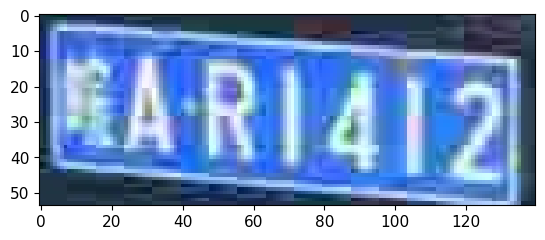

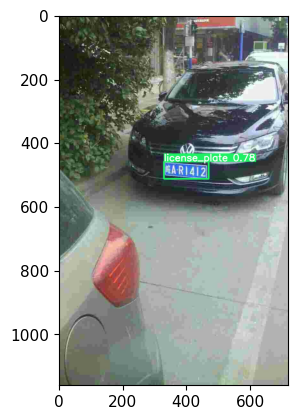

['连AR1412']
CCPD_data\ccpd_base\00737547892721-90_86-290&471_444&529-441&538_287&535_288&483_442&486-0_0_32_25_11_25_31-75-9.jpg


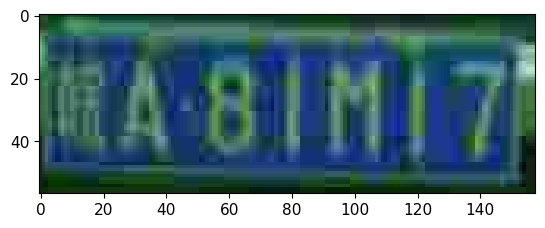

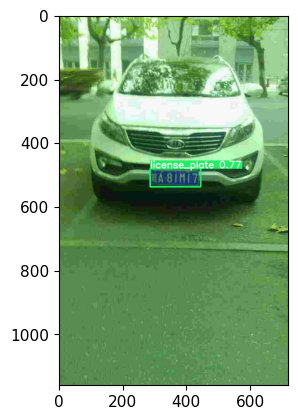

['A81N7']
CCPD_data\ccpd_base\00741259578545-90_86-227&577_397&637-390&633_227&628_226&574_389&579-0_0_6_9_29_32_27-66-5.jpg


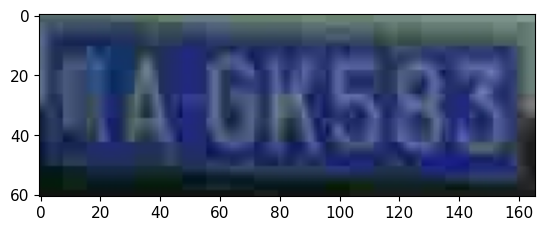

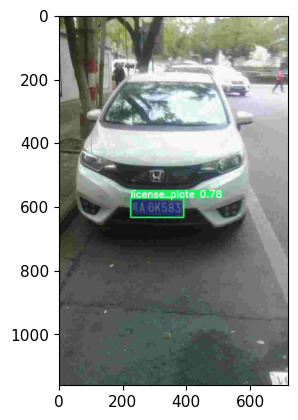

['味AGH583']


In [37]:
%matplotlib inline
idxs = [0, 50, 100, 150, 200]
for idx in idxs:
    show_plate_detection(idx)
    text_ocr = get_text_cnocr(idx)
    print(text_ocr)

<div>
    <h2 id = "title"
        style = "background-color: #2788f9;
                 border-radius: 9px;
                 color: #f8f8f8;
                 line-height: 50px;
                 padding: 15px 0px 15px 20px; 
                 text-align: center;
                 font-size: 28px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">To be continued
    </h2>
</div>

<div class="alert alert-block alert-info" style="color: black; font-size: 15px; font-family: Trebuchet MS">
    <b>References</b>:
    <ul>
        <li>CCPD (Chinese City Parking Dataset, ECCV): <a href="https://github.com/detectRecog/CCPD"><u>https://github.com/detectRecog/CCPD</u></a></li>
        <li>Towards End-to-End License Plate Detection and Recognition: A Large Dataset and Baseline; Xu, Zhenbo and Yang, Wei and Meng, Ajin and Lu, Nanxue and Huang, Huan; Proceedings of the European Conference on Computer Vision (ECCV); 255--271; 2018</li>
        <li>Automatic Number Plate Recognition Notebook - Aslan Ahmedov: <a href="https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition"><u>https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition</u></a></li>
    </ul>
    <b>Improvements</b>:
    <ul>
        <li>Improve image quality to get better text extraction results after cropping from model detection.</li>
        <li>It can use a model that performs both plate detection and recognition simultaneously such as RPNet from main paper sources.</li>
    </ul>
</div>